# SVC Backtesting

In [ ]:
# All the import statements we need for preprocessing the data 
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
import yfinance as yf
from sklearn.preprocessing import StandardScaler

# Setting a random seed
np.random.seed(42)

# Cleaning and reading the csv file 
df = pd.read_csv("../Data/^GSPC.csv")
df = df[df["Price"] != "Ticker"]
df = df[df["Price"] != "Date"]
df[['Close','High', 'Low', 'Open', 'Volume']] = df[['Close', 'High', 'Low', 'Open', 'Volume']].astype(float)
df['Price'] = pd.to_datetime(df['Price'])
df.set_index('Price', inplace=True)
df.index.name = None

# This function adds technical indicators and features to the data 
def add_features(data):
    df = data.copy()

    # These are the technical indicators that we will use from the yfinance library
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Close'].pct_change().rolling(window=10).std()
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    df['Return'] = df['Close'].pct_change()

    # These are features that we engineered from the technical indicators that we will use for our model. We added the 
    # X_ prefix to the features to indicate that they are engineered features
    df['X_MA5'] = (df['Close'] - df['MA5']) / df['Close']
    df['X_MA10'] = (df['Close'] - df['MA10']) / df['Close']
    df['X_MA20'] = (df['Close'] - df['MA20']) / df['Close']
    df['X_MA5_10'] = (df['MA5'] - df['MA10']) / df['Close']
    df['X_MA10_20'] = (df['MA10'] - df['MA20']) / df['Close']
    df['X_Volatility'] = df['Volatility']
    df['X_Momentum'] = df['Momentum']
    df['X_Return'] = df['Return']
    df['X_Return_5'] = df['Return'].rolling(5).sum()
    df['X_VOL_CHG'] = df['Volume'].pct_change(5)
    # The 'Target' column is a ternary classification problem with labels -1, 0, and 1 indicating down, neutral, and up movements
    df['Target'] = np.where(df['Return'].shift(-1) > 0.005, 1,
                    np.where(df['Return'].shift(-1) < -0.005, -1, 0))

    return df  

# The get_X and get_y functions are helper functions that extract features and labels from the data
def get_X(data):
    feature_columns = [col for col in data.columns if col.startswith('X_')]
    return data[feature_columns].values
def get_y(data):
    return data.Target.values

# We apply the features to the dataframe 
df = add_features(df)

/Users/aroncheng/backtest-env/lib/python3.9/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [ ]:
from sklearn.svm import SVC

class strategy_class(Strategy):
    def init(self):
        self.model = SVC(probability=True, random_state=42) # Initialize the SVC model
        self.features = [col for col in self.data.df.columns if col.startswith("X_")] # List of features
        self.df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill') # Fill NaN values

        self.pred = self.I(lambda: np.zeros(len(self.data)), name='pred') # Initialize the prediction array
        self.predictions = []
        self.actuals = []

    def next(self):
        i = len(self.data)
        # Ensure we have enough data to train the model
        if i < 200:
            return
        # Prepare training and test data
        # We use the last 200 data points for training and the last data point for testing
        train = self.df.iloc[i-200:i]
        test = self.df.iloc[[i-1]] 
        X_train = train[self.features].values
        y_train = train["Target"].values 
        X_test = test[self.features].values
        y_true = test["Target"].values[0]
        self.model.fit(X_train, y_train) # fits the training model
        prediction = self.model.predict(X_test)[0] # fits the test model
        self.pred[-1] = prediction

        # Store prediction and actual label
        if prediction in [-1, 0, 1]:
            self.predictions.append(prediction)
            self.actuals.append(int(y_true))

        # this is the trading prediction 
        if prediction == 1:
            if not self.position.is_long:
                self.position.close()
                self.buy()
        elif prediction == -1:
            if not self.position.is_short:
                self.position.close()
                self.sell()

In [6]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_strategy(y_true, y_pred):
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Precision:", round(precision_score(y_true, y_pred, average='macro'), 4))
    print("F1 Score:", round(f1_score(y_true, y_pred, average='macro'), 4))

    cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Down (-1)', 'Neutral (0)', 'Up (1)'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

In [7]:

bt = Backtest(df, strategy_class, cash=10000, commission=0.002)
backtest = bt.run()
backtest

/var/folders/46/zqdj50yj7l759m_vn_js8z0w0000gn/T/ipykernel_72820/3738966094.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')


Start                     2020-01-30 00:00:00
End                       2023-12-29 00:00:00
Duration                   1429 days 00:00:00
Exposure Time [%]                    66.56535
Equity Final [$]                  11212.51613
Equity Peak [$]                   14405.04606
Commissions [$]                    2368.77785
Return [%]                           12.12516
Buy & Hold Return [%]                45.25956
Return (Ann.) [%]                     2.96512
Volatility (Ann.) [%]                12.37836
CAGR [%]                              2.03872
Sharpe Ratio                          0.23954
Sortino Ratio                         0.34628
Calmar Ratio                          0.09497
Alpha [%]                             8.01539
Beta                                   0.0908
Max. Drawdown [%]                   -31.22135
Avg. Drawdown [%]                    -2.02931
Max. Drawdown Duration      455 days 00:00:00
Avg. Drawdown Duration       21 days 00:00:00
# Trades                          

Accuracy: 0.4797
Precision: 0.4425
F1 Score: 0.438


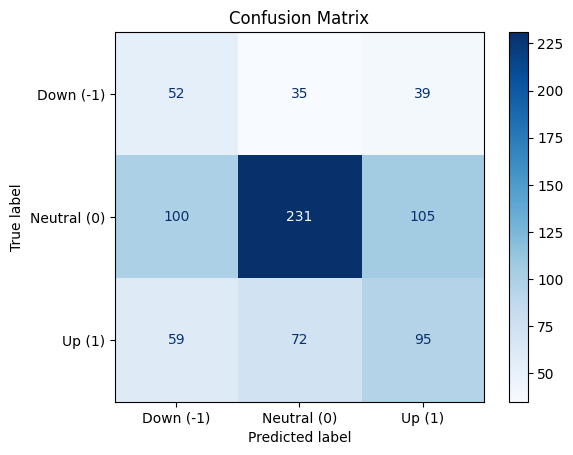

In [8]:
predictions = backtest._strategy.predictions
actuals = backtest._strategy.actuals
evaluate_strategy(predictions, actuals)

In [9]:
bt.plot()

/Users/aroncheng/backtest-env/lib/python3.9/site-packages/backtesting/_plotting.py:701: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/Users/aroncheng/backtest-env/lib/python3.9/site-packages/backtesting/_plotting.py:701: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p1366', ...)